##### **Quick overview of this post**

-   Short introduction of random forest
-   Random forest methods or classes in *scikit-learn*
-   Random forest regressor model in *scikit-learn*
-   Training and testing data splits
    -   ChEMBL-assigned max phase splits
    -   Imbalanced learning regression and max phase splits
-   Scoring metrics of trained models
-   Feature importances in dataset
    -   feature_importances_attribute in *scikit-learn*
    -   permutation_importance function in *scikit-learn*
    -   SHAP approach
-   Hyperparameter tuning on number of trees

<br>

##### **What is a random forest?**

The [decision tree model built last time](https://jhylin.github.io/Data_in_life_blog/posts/16_ML2-1_Decision_tree/3_model_build.html) was purely based on one model on its own, which often might not be as accurate or reflective in real-life. To improve the model, the average outcome from multiple models [@breiman1998] should be considered to see if this would provide a more realistic image. This model averaging approach was also constantly used in our daily lives, for example, using majority votes during decision-making steps.

The same model averaging concept was also used in random forest [@breiman2001], which as the name suggested, was composed of many decision trees (models) forming a forest. Each tree model would be making its own model prediction. By accruing multiple predictions since we have multiple trees, the average obtained from these predictions would produce one single result in the end. The advantage of this was that it improved the accuracy of the prediction by reducing variances, and also minimised the problem of overfitting the model if it was purely based on one model only (more details in section 1.11.2.1. Random Forests from [*scikit-learn*](https://scikit-learn.org/stable/modules/ensemble.html#random-forests)).

The "random" part of the random forest was introduced in two ways. The first one was via using bootstrap samples, which was also known as bagging or bootstrap aggregating [@bruce2020], where samples were drawn with replacements within the training datasets for each tree built in the ensemble (also known as the perturb-and-combine technique [@breiman1998]). While bootstrap sampling was happening, randomness was also incorporated into the training sets at the same time. The second way randomness was introduced was by using a random subset of features for splitting at the nodes, or a full set of features could also be used (although this was generally not recommended). The main goal here was to achieve best splits at each node.

<br>

##### **Random forest in *scikit-learn***

*Scikit-learn* had two main types of random forest classes - [ensemble.RandomForestClassifier()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) and [ensemble.RandomForestRegressor()](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor). When to use which class would depend on the target values. The easiest thing to do was to decide whether the target variables had class labels (binary types or non-continuous variables e.g. yes or no, or other different categories to be assigned) or continuous (numerical) variables, which in this case, if I were to continue using the same dataset from the decision tree series, it would be a continuous variable or feature, pKi, the inhibition constant.

There were also two other alternative random forest methods in *scikit-learn*, which were ensemble.RandomTreesEmbedding() and ensemble.ExtraTreesClassifier() or ensemble.ExtraTreesRegressor(). The difference for RandomTreesEmbedding() was that it was an unsupervised method that used data transformations (more details from section 1.11.2.6. on "Totally Random Trees Embedding" in [*scikit-learn*](https://scikit-learn.org/stable/modules/ensemble.html#totally-random-trees-embedding)). On the other side, there was also an option to use ExtraTreesClassifier() or ExtraTreesRegressor() to generate extremely randomised trees that would go for another level up in randomness (more deatils in section 1.11.2.2. on Extremely Randomized Trees from [*scikit-learn*](https://scikit-learn.org/stable/modules/ensemble.html#extremely-randomized-trees)). The main difference for this type of random forest was that while there was already a random subset of feature selection used (with an intention to select the most discerning features), more randomness were added on top of this by using purely randomly generated splitting rules for picking features at the nodes. The advantage of this type of method was that it would reduce variance and increase the accuracy of the model, but the downside was there might be an increase in bias within the model.

<br>

##### **Building a random forest regressor model using *scikit-learn***

As usual, all the required libraries were imported first.

In [1]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestRegressor

# For imbalanced datasets in regression 
import ImbalancedLearningRegression as iblr

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Feature importances
# Permutation_importance
from sklearn.inspection import permutation_importance
# SHAP values
import shap

# Hyperparameter tuning
from sklearn.model_selection import cross_val_score, RepeatedKFold

from numpy import mean, std
from natsort import index_natsorted
import numpy as np

# Showing version of scikit-learn used
print(sklearn.__version__)

1.3.1


Importing dataset that was preprocessed from last time - link to data source: [first decision tree post](https://jhylin.github.io/Data_in_life_blog/posts/16_ML2-1_Decision_tree/1_data_col_prep.html).

In [2]:
data = pd.read_csv("ache_2d_chembl.csv")
data.drop(columns = ["Unnamed: 0"], inplace=True)
# Preparing data for compounds with max phase with "NaN" by re-labelling to "null"
data["max_phase"].fillna("null", inplace=True)
data.head()

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'null' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


,molecule_chembl_id,pKi,max_phase,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL60745,8.787812,null,245.041526,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0
1,CHEMBL208599,10.585027,null,298.123676,0.388889,2,2,4,3,21,...,4.331775,2,0,2,1,1,2,0,0,0
2,CHEMBL95,6.821023,4.0,198.115698,0.307692,2,2,3,2,15,...,2.014719,1,0,1,1,1,2,0,0,0
3,CHEMBL173309,7.913640,null,694.539707,0.666667,8,0,2,8,50,...,2.803680,0,0,0,2,0,2,0,0,0
4,CHEMBL1128,6.698970,4.0,201.092042,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0


<br>

##### **Training/testing splits**

Two approaches were used, where one was based purely on max phase split (between max phases null and 4), which was used last time in the decision tree series, and the other one was using the same max phase split but with an ImbalancedLearningRegression method added on top of it.

<br>

###### **Preparing training data using max phase split**

X variable was set up first from the dataframe, and then converted into a NumPy array, which consisted of the number of samples and number of features. This was kept the same as how it was in the decision tree posts.

::: callout-note
It's usually recommended to copy the original data or dataframe before doing any data manipulations to avoid unnecessary changes to the original dataset (this was not used in the decision tree posts, but since I'm going to use the same set of data again I'm doing it here.)
:::

In [3]:
# X variables (molecular features)
# Make a copy of the original dataframe first
data_mp4 = data.copy()
# Selecting all max phase 4 compounds
data_mp4 = data_mp4[data_mp4["max_phase"] == 4]
print(data_mp4.shape)
data_mp4.head()

(10, 25)


,molecule_chembl_id,pKi,max_phase,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
2,CHEMBL95,6.821023,4.0,198.115698,0.307692,2,2,3,2,15,...,2.014719,1,0,1,1,1,2,0,0,0
4,CHEMBL1128,6.698970,4.0,201.092042,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0
6,CHEMBL640,6.000000,4.0,235.168462,0.461538,4,3,1,4,17,...,1.791687,0,0,0,1,0,1,0,0,0
9,CHEMBL502,7.688246,4.0,379.214744,0.458333,4,0,4,4,28,...,2.677222,1,1,2,2,0,2,0,1,1
131,CHEMBL481,7.296709,4.0,586.279135,0.515152,10,1,7,10,43,...,3.632560,0,4,4,1,2,3,0,2,2


In [4]:
# Select molecular features for X array (n_samples, n_features)
X_mp4_df = data_mp4[['mw', 'fsp3', 'n_lipinski_hba', 'n_lipinski_hbd', 'n_rings', 'n_hetero_atoms', 'n_heavy_atoms', 'n_rotatable_bonds', 'n_radical_electrons', 'tpsa', 'qed', 'clogp', 'sas', 'n_aliphatic_carbocycles', 'n_aliphatic_heterocyles', 'n_aliphatic_rings', 'n_aromatic_carbocycles', 'n_aromatic_heterocyles', 'n_aromatic_rings', 'n_saturated_carbocycles', 'n_saturated_heterocyles', 'n_saturated_rings']]

print(X_mp4_df.shape)
X_mp4_df.head()

(10, 22)


,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
2,198.115698,0.307692,2,2,3,2,15,0,0,38.91,...,2.014719,1,0,1,1,1,2,0,0,0
4,201.092042,0.400000,2,1,1,3,13,2,0,20.23,...,3.185866,0,0,0,1,0,1,0,0,0
6,235.168462,0.461538,4,3,1,4,17,6,0,58.36,...,1.791687,0,0,0,1,0,1,0,0,0
9,379.214744,0.458333,4,0,4,4,28,6,0,38.77,...,2.677222,1,1,2,2,0,2,0,1,1
131,586.279135,0.515152,10,1,7,10,43,4,0,114.20,...,3.632560,0,4,4,1,2,3,0,2,2


In [5]:
# Convert X_mp4_df to numpy array
X_mp4 = X_mp4_df.to_numpy()
X_mp4

array([[ 1.98115698e+02,  3.07692308e-01,  2.00000000e+00,
         2.00000000e+00,  3.00000000e+00,  2.00000000e+00,
         1.50000000e+01,  0.00000000e+00,  0.00000000e+00,
         3.89100000e+01,  7.06488238e-01,  2.69580000e+00,
         2.01471913e+00,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         2.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.01092042e+02,  4.00000000e-01,  2.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  3.00000000e+00,
         1.30000000e+01,  2.00000000e+00,  0.00000000e+00,
         2.02300000e+01,  6.08112327e-01, -1.01700000e+00,
         3.18586632e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.35168462e+02,  4.61538462e-01,  4.00000000e+00,
         3.00000000e+00,  1.00000000e+00,  4.00000000e+00,
    

Again, y variable was arranged via the dataframe as well, and converted into a NumPy array. It consisted of the number of samples only as this was the target variable.

In [6]:
# y array (n_samples) - target outcome pKi
y_mp4_df = data_mp4["pKi"]
y_mp4_df

2      6.821023
4      6.698970
6      6.000000
9      7.688246
131    7.296709
133    4.431798
160    5.221849
171    6.522879
180    4.607303
195    6.995679
Name: pKi, dtype: float64

In [7]:
# Convert y_mp4_df to numpy array
y_mp4 = y_mp4_df.to_numpy()
y_mp4

array([6.82102305, 6.69897   , 6.        , 7.68824614, 7.29670862,
       4.43179828, 5.22184875, 6.52287875, 4.60730305, 6.99567863])

<br>

###### **Training model using max phase split only**

Both X and y variables were used to fit the RandomForestRegressor() estimator.

In [8]:
# n_estimators = 100 by default
# note: if wanting to use whole dataset - switch off "bootstrap" parameter by using "False"
rfreg = RandomForestRegressor(max_depth=3, random_state=1)
rfreg.fit(X_mp4, y_mp4)

RandomForestRegressor(max_depth=3, random_state=1)

<br>

###### **Preparing testing data using max phase split only**

Testing data was mainly based on compounds with max phase assigned as "0" or "null" after I renamed it above.

In [9]:
data_mp_null = data.copy()
# Selecting all max phase "null" compounds
data_mp_null = data_mp_null[data_mp_null["max_phase"] == "null"]
print(data_mp_null.shape)
data_mp_null.head() 

(466, 25)


,molecule_chembl_id,pKi,max_phase,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL60745,8.787812,null,245.041526,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0
1,CHEMBL208599,10.585027,null,298.123676,0.388889,2,2,4,3,21,...,4.331775,2,0,2,1,1,2,0,0,0
3,CHEMBL173309,7.913640,null,694.539707,0.666667,8,0,2,8,50,...,2.803680,0,0,0,2,0,2,0,0,0
5,CHEMBL102226,4.698970,null,297.152928,0.923077,3,0,0,5,18,...,2.965170,0,0,0,0,0,0,0,0,0
7,CHEMBL103873,5.698970,null,269.121628,0.909091,3,0,0,5,16,...,3.097106,0,0,0,0,0,0,0,0,0


In [10]:
# Set up X test variable with the same molecular features
X_mp_test_df = data_mp_null[['mw', 'fsp3', 'n_lipinski_hba', 'n_lipinski_hbd', 'n_rings', 'n_hetero_atoms', 'n_heavy_atoms', 'n_rotatable_bonds', 'n_radical_electrons', 'tpsa', 'qed', 'clogp', 'sas', 'n_aliphatic_carbocycles', 'n_aliphatic_heterocyles', 'n_aliphatic_rings', 'n_aromatic_carbocycles', 'n_aromatic_heterocyles', 'n_aromatic_rings', 'n_saturated_carbocycles', 'n_saturated_heterocyles', 'n_saturated_rings']]

# Convert X test variables from df to arrays
X_mp_test = X_mp_test_df.to_numpy()

X_mp_test

array([[2.45041526e+02, 4.00000000e-01, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.98123676e+02, 3.88888889e-01, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.94539707e+02, 6.66666667e-01, 8.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.11152144e+02, 3.15789474e-01, 4.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.68096076e+02, 9.23076923e-01, 4.00000000e+00, ...,
        0.00000000e+00, 2.00000000e+00, 2.00000000e+00],
       [2.46136828e+02, 5.00000000e-01, 4.00000000e+00, ...,
        0.00000000e+00, 3.00000000e+00, 3.00000000e+00]])

<br>

###### **Training/testing splits using ImbalancedLearningRegression and max phase splits**

I didn't really pay a lot of attentions when I was doing data splits in the decision tree series, as my main focus was on building a single tree in order to fully understand and see what could be derived from just one tree. Now, when I reached this series on random forest, I realised I forgot to mention in the last series that data splitting was actually very crucial on model performance and could influence outcome predictions. It could also become quite complicated as more approaches were available to split the data. Also, the way the data was splitted could produce different outcomes.

After I've splitted the same dataset based on compounds' max phase assignments in ChEMBL and also fitted the training data on the random forest regressor, I went back and noticed that the training and testing data were very imbalanced and I probably should do something about it before fitting them onto another model.

At this stage, I went further to look into whether imbalanced datasets should be addressed in regression tasks, and did a surface search online. So based on common ML concensus, addressing imbalanced datasets were more applicable to classification tasks (e.g. binary labels or multi-class labels), rather than regression problems. However, recent ML research looked into the issue of imbalanced datasets in regression. This [blog post](https://neptune.ai/blog/how-to-deal-with-imbalanced-classification-and-regression-data) mentioned a few studies that looked into this type of problem, and I thought they were very interesting and worth a mention at least. One of them that I've looked into was SMOTER, which was based on synthetic minority over-sampling technique (SMOTE)[@chawla2002], and was named this way because it was basically a SMOTE for regression (hence SMOTER)[@torgo2013]. Synthetic minority over-sampling technique for regression with Gaussian noise (SMOGN)[@smogn] was another technique that was built upon SMOTER, but with Gaussian noises added. This has subsequently led me to ImbalancedLearningRegression library [@wu2022imbalancedlearningregression], which was a variation of SMOGN. This was the one used on my imbalanced dataset, shown in the section below.

A simple flow diagram was drawn below showing the evolution of different techniques when dealing with imbalanced datasets in classification (SMOTE) and regression (SMOTER, SMOGN and ImbalancedLearningRegression):

```{mermaid}
flowchart LR
  A(SMOTE) --> B(SMOTER)
  B --> C(SMOGN)
  C --> D(ImbalancedLearningRegression)
```

GitHub repository for ImbalancedLearningRegression package is available [here](https://github.com/paobranco/ImbalancedLearningRegression), with its documentation available [here](https://imbalancedlearningregression.readthedocs.io/en/latest/intro.html).

Also, I just wanted to mention that these were not the only techniques available for treating imbalanced datasets in regression, as there were other ones in the literature and most likely more are being developed currently, but I only had time to cover these here for now.

I also would like to mention another really useful open-source resource for treating imbalanced datasets in classifications since I did not use it in this post due to the problem being more of a regression one than a classification one - [imbalance-learn library](https://imbalanced-learn.org/stable/index.html#).

In [11]:
# Original dataset - checking shape again
print(data.shape)
data.head()

(481, 25)


,molecule_chembl_id,pKi,max_phase,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL60745,8.787812,null,245.041526,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0
1,CHEMBL208599,10.585027,null,298.123676,0.388889,2,2,4,3,21,...,4.331775,2,0,2,1,1,2,0,0,0
2,CHEMBL95,6.821023,4.0,198.115698,0.307692,2,2,3,2,15,...,2.014719,1,0,1,1,1,2,0,0,0
3,CHEMBL173309,7.913640,null,694.539707,0.666667,8,0,2,8,50,...,2.803680,0,0,0,2,0,2,0,0,0
4,CHEMBL1128,6.698970,4.0,201.092042,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0


So my little test on using ImbalancedLearningRegression package started from below.

In [12]:
iblr_data = data.copy()

# Introducing Gaussian noise for data sampling
data_gn = iblr.gn(data = iblr_data, y = "pKi", pert = 1)
print(data_gn.shape)

r_index: 100%|##########| 8/8 [00:00<00:00, 156.65it/s]


(480, 25)


In [13]:
# Followed by max phase split, where max phase 4 = training dataset
data_gn_mp4 = data_gn[data_gn["max_phase"] == 4]
data_gn_mp4
print(data_gn_mp4.shape)

(7, 25)


In [14]:
# Also splitted max phase null compounds = testing dataset
data_gn_mp_null = data_gn[data_gn["max_phase"] == "null"]
data_gn_mp_null
print(data_gn_mp_null.shape)

(469, 25)


There were several different sampling techniques in ImbalancedLearningRegression package. I've only tried random over-sampling, under-sampling and Gaussian noise, but there were also other ones such as SMOTE and ADASYN (in over-sampling technique) or condensed nearest neighbor, Tomeklinks and edited nearest neightbour (in under-sampling technique) that I haven't used.

Random over-sampling actually oversampled the max phase null compounds (sample size increased), while keeping all 10 max phase 4 compounds. Under-sampling removed all of the max phase 4 compounds (which was most likely not the best option, since I was aiming to use them as training compounds), with max phase null compounds also reduced in size too. Due to post length, I did not show the code for random over-sampling and under-sampling, but for people who are interested, I think it would be interesting to test them out.

I ended up using Gauissian noise sampling and it reduced max phase 4 compounds slightly, and increased the max phase null compounds a little bit too, which seemed to be the most balanced data sampling at the first try. (Note: as stated from the documentation for ImbalancedLearningRegression package, missing values within features would be removed automatically, I've taken care of this in my last series of posts so no difference were observed here.)

The change in the distribution of pKi values for the Gaussian noise sampling method between the original and sample-modified datasets could be seen in the kernel density estimate plot below. The modified dataset had a flatter target density curve than the original density plot, which was more concentrated and peaked between pKi values of 6 and 8. The range of pKi values for the ten max phase 4 compounds collected was between 4 and 8.

[*Plot reference*](https://github.com/paobranco/ImbalancedLearningRegression/blob/master/examples/Gaussian_noise.ipynb)

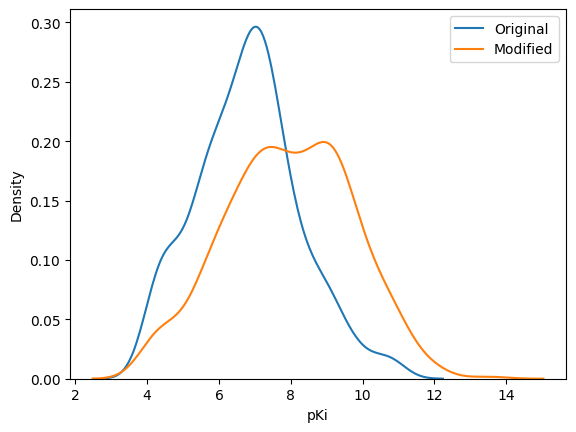

In [15]:
# Quick look at how the pKi values differed 
# after applying Gaussian noise sampling to dataset
# Plot target variable, pKi distributions
sns.kdeplot(data["pKi"], label = "Original")
sns.kdeplot(data_gn["pKi"], label = "Modified")
plt.legend(labels = ["Original", "Modified"])

Next, the modified ImbalancedLearningRegression-Gaussian noise (iblr-gn) training data was converted into a NumPy array.

In [16]:
# Select molecular features for X variable
X_mp4_gn_df = data_gn_mp4[['mw', 'fsp3', 'n_lipinski_hba', 'n_lipinski_hbd', 'n_rings', 'n_hetero_atoms', 'n_heavy_atoms', 'n_rotatable_bonds', 'n_radical_electrons', 'tpsa', 'qed', 'clogp', 'sas', 'n_aliphatic_carbocycles', 'n_aliphatic_heterocyles', 'n_aliphatic_rings', 'n_aromatic_carbocycles', 'n_aromatic_heterocyles', 'n_aromatic_rings', 'n_saturated_carbocycles', 'n_saturated_heterocyles', 'n_saturated_rings']]

print(X_mp4_gn_df.shape)
X_mp4_gn_df.head()

(7, 22)


,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,n_rotatable_bonds,n_radical_electrons,tpsa,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
281,198.115698,0.307692,2.0,2.0,3.0,2.0,15.0,0.0,0,38.91,...,2.014719,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0
379,235.168462,0.461538,4.0,3.0,1.0,4.0,17.0,6.0,0,58.36,...,1.791687,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
402,201.092042,0.400000,2.0,1.0,1.0,3.0,13.0,2.0,0,20.23,...,3.185866,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
443,184.066459,1.000000,3.0,0.0,0.0,5.0,11.0,4.0,0,35.53,...,3.345144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446,348.142697,0.368421,2.0,0.0,3.0,4.0,23.0,5.0,0,6.48,...,4.223591,0.0,1.0,1.0,2.0,0.0,2.0,0.0,0.0,0.0


In [17]:
X_mp4_gn = X_mp4_gn_df.to_numpy()

Similarly, this was also applied to the target y variable in the iblr-gn dataset.

In [18]:
# y variable (target outcome - pKi)
y_mp4_gn_df = data_gn_mp4["pKi"]

y_mp4_gn = y_mp4_gn_df.to_numpy()
y_mp4_gn

array([6.82102305, 6.        , 6.69897   , 5.22184875, 4.60730305,
       6.52287875, 7.29670862])

Then the iblr-gn training data were fitted onto another random forest regressor model.

In [19]:
# n_estimators = 100 by default
# note: if wanting to use whole dataset - switch off "bootstrap" parameter by using "False"
rfreg_gn = RandomForestRegressor(max_depth=3, random_state=1)
rfreg_gn.fit(X_mp4_gn, y_mp4_gn)

RandomForestRegressor(max_depth=3, random_state=1)

Modified iblr-gn testing data were also prepared and converted into a NumPy array.

In [20]:
# Set up X test variable with the same molecular features
X_mp_gn_test_df = data_gn_mp_null[['mw', 'fsp3', 'n_lipinski_hba', 'n_lipinski_hbd', 'n_rings', 'n_hetero_atoms', 'n_heavy_atoms', 'n_rotatable_bonds', 'n_radical_electrons', 'tpsa', 'qed', 'clogp', 'sas', 'n_aliphatic_carbocycles', 'n_aliphatic_heterocyles', 'n_aliphatic_rings', 'n_aromatic_carbocycles', 'n_aromatic_heterocyles', 'n_aromatic_rings', 'n_saturated_carbocycles', 'n_saturated_heterocyles', 'n_saturated_rings']]

# Convert X test variables from df to arrays
X_mp_gn_test = X_mp_gn_test_df.to_numpy()

X_mp_gn_test

array([[5.80224119e+02, 2.64705882e-01, 7.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.77210327e+02, 3.91304348e-01, 5.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [5.24297368e+02, 4.54545455e-01, 4.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.73158040e+02, 5.00000000e-01, 5.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.60173607e+02, 8.33333333e-01, 6.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.41216475e+02, 2.69230769e-01, 7.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

<br>

###### **Using trained model for prediction on testing data**

Predicting max phase-splitted data only.

In [21]:
# Predict pKi values for the compounds with "null" max phase
# using the training model rfreg 
# Uncomment code below to print prediction result
#print(rfreg.predict(X_mp_test))

# or use:
y_mp_test = rfreg.predict(X_mp_test)

Predicting iblr-gn data with max phase splits.

In [22]:
y_mp_gn_test = rfreg_gn.predict(X_mp_gn_test)

<br>

###### **Scoring and metrics of trained models**

Checking model accuracy for both training and testing datasets was recommended to take place before moving onto discovering feature importances. A *scikit-learn* explanation for this could be found in the section on ["Permutation feature importance"](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-feature-importance). So the accuracy scores for the model were shown below.

In [23]:
# Training set accuracy
print(f"Random forest regressor training accuracy: {rfreg.score(X_mp4, y_mp4):.2f}")

# Testing set accuracy
print(f"Random forest regressor testing accuracy: {rfreg.score(X_mp_test, y_mp_test):.2f}")

Random forest regressor training accuracy: 0.82
Random forest regressor testing accuracy: 1.00


It looked like both the training and testing accuracies for the random forest regressor model (rfreg) were quite high, meaning that the model was able to remember the molecular features well from the training set (the tiny sample of 10 compounds), and the model was able to apply them to the testing set (which should contain about 400 or so compounds) as well, in order to make predictions on the target value of pKi. This has somewhat confirmed that the model was indeed making predictions, rather than not making any predictions at all, which meant there might be no point in finding out which features were important in the data. Therefore, we could now move onto processing the feature importances to fill in the bigger story i.e. which features were more pivotal towards influencing pKi values of approved drugs targeting acetylcholinesterase (AChE).

Similar model accuracy scores were also generated for the iblr-gn modified dataset, which appeared to follow a similar pattern as the max phase-splitted dataset.

In [24]:
# iblr-Gaussian noise & max phase splitted data
# Training set accuracy
print(f"Random forest regressor training accuracy: {rfreg_gn.score(X_mp4_gn, y_mp4_gn):.2f}")

# Testing set accuracy
print(f"Random forest regressor testing accuracy: {rfreg_gn.score(X_mp_gn_test, y_mp_gn_test):.2f}")

Random forest regressor training accuracy: 0.84
Random forest regressor testing accuracy: 1.00


Now, setting up the y_true, which was the acutal pKi values of the testing set, and were converted into a NumPy array too.

In [25]:
y_true = data_mp_null["pKi"]
y_true = y_true.to_numpy(copy=True)

I also found out the mean squared error (MSE) between y_true (actual max phase null compounds' pKi values) and y_pred (predicted max phase null compounds' pKi values). When MSE was closer to zero, the better the model was, meaning less errors were present.

Some references that might help with explaining MSE:

- [*scikit-learn* link](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error)
- [Stats StackExchange link](https://stats.stackexchange.com/questions/579755/whats-a-reasonable-mean-squared-error-or-rmse)
- [blog post link](https://statisticsbyjim.com/regression/mean-squared-error-mse/) 

In [26]:
# For max phase splitted dataset only
mean_squared_error(y_true, y_mp_test)

2.330350086602576

When R^2^ (coefficient of determination) was closer to 1, the better the model is, with a usual range between 0 and 1 [@bruce2020]. If it was negative, then the model might not be performing as well as expected. However, there could be exceptions as other model evaluation methods should also be interpreted together with R^2^ (a poor R^2^ might not be wholly indicating it's a poor model).

Some references that might help with understanding R^2^:

- [Stats StackExchange link](https://stats.stackexchange.com/questions/414349/is-my-model-any-good-based-on-the-diagnostic-metric-r2-auc-accuracy-rmse)
- [*scikit-learn* link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)


In [27]:
# For max phase splitted dataset only
r2_score(y_true, y_mp_test)

-0.12911187644281164

Because the data was re-sampled in a iblr-gn way, the size of array would be different from the original dataset, so here I've specifically grabbed pKi values from the iblr-gn modified data to get the actual pKi values for the max phase null compounds.

In [28]:
y_true_gn = data_gn_mp_null["pKi"]
y_true_gn = y_true_gn.to_numpy(copy=True)

In [29]:
# MSE for iblr-gn data
mean_squared_error(y_true_gn, y_mp_gn_test)

6.147616079212892

In [30]:
# R squared for iblr-gn data
r2_score(y_true_gn, y_mp_gn_test)

-1.043521505864915

Well, it appeared iblr-gn dataset might not offer much advantage than the original max phase splitted method. However, even the max phase splitted method wasn't that great either, but it might still be interesting to find out which features were important in relation to the pKi values.

<br>

##### **Feature importances**

There were two types of feature importances available in *scikit-learn*, which I've described below. I've also added a Shapley additive explanations (SHAP) approach to this section as well to show different visualisation styles for feature importances on the same set of data.

<br>

###### **feature_importances\_ attribute from *scikit-learn***

The impurity-based feature importances (also known as Gini importance) were shown below.

In [31]:
# Compute feature importances on rfreg training model
feature_imp = rfreg.feature_importances_

In [32]:
# Check what feature_imp looks like (an array)
feature_imp

array([0.01845843, 0.0833086 , 0.00414526, 0.17344377, 0.02473391,
       0.03119123, 0.03215709, 0.01706784, 0.        , 0.21772693,
       0.03390372, 0.16184532, 0.07451324, 0.029626  , 0.00256679,
       0.01350827, 0.02132237, 0.00666429, 0.02731864, 0.        ,
       0.01323578, 0.01326253])

I decided to write a function to convert a NumPy array into a plot below as this was also needed in the next section.

In [33]:
# Function to convert array to df leading to plots 
# - for use in feature_importances_ & permutation_importance

def feat_imp_plot(feat_imp_array, X_df):

    """
    Function to convert feature importance array into a dataframe, 
    which is then used to plot a bar graph 
    to show the feature importance ranking in the random forest model for the dataset used.

    feat_imp_array is the array obtained from the feature_importances_ attribute, 
    after having a estimator/model fitted.

    X_df is the dataframe for the X variable, 
    where the feature column names will be used in the plot.
    """

    # Convert the feat_imp array into dataframe
    feat_imp_df = pd.DataFrame(feat_imp_array)
    
    # Obtain feature names via column names of dataframe
    # Rename the index as "features"
    feature = X_df.columns.rename("features")

    # Convert the index to dataframe
    feature_name_df = feature.to_frame(index = False)

    # Concatenate feature_imp_df & feature_name_df
    feature_df = pd.concat(
        [feat_imp_df, feature_name_df], 
        axis=1
        ).rename(
            # Rename the column for feature importances
            columns = {0: "feature_importances"}
            ).sort_values(
                # Sort values of feature importances in descending order
                "feature_importances", ascending=False
                )
    
    # Seaborn bar plot
    sns.barplot(
        feature_df, 
        x = "feature_importances", 
        y = "features")

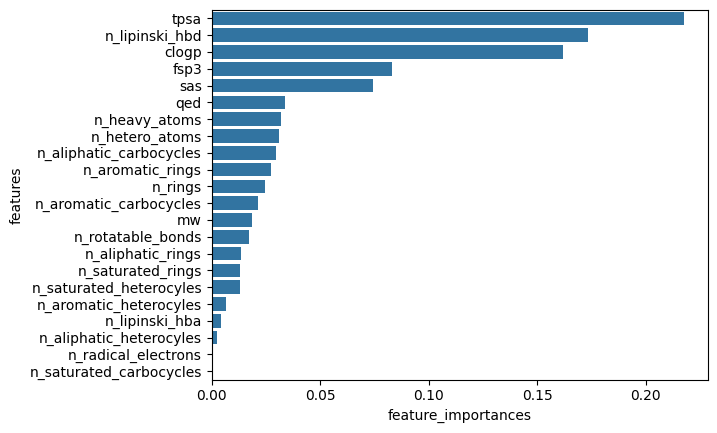

In [34]:
# Testing feat_imp_plot function
feat_imp_plot(feature_imp, X_mp4_df)

An alternative way to plot was via Matplotlib directly (note: Seaborn was built based on Matplotlib, so the plots were pretty similar). The code below were probably a bit more straightforward but without axes named and the values were not sorted (only as an example but more code could be added to do this).

<BarContainer object of 22 artists>

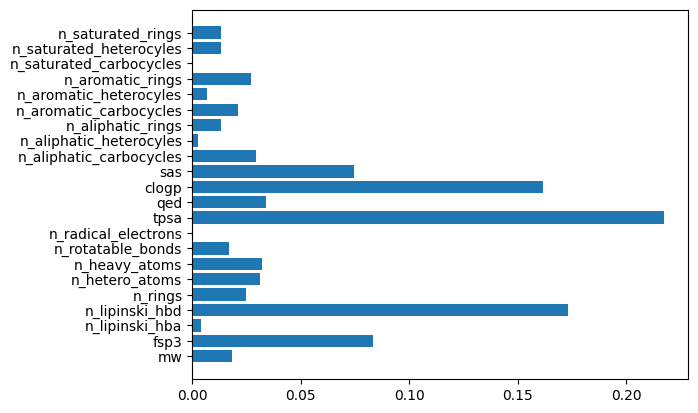

In [35]:
# Matplotlib plot
from matplotlib import pyplot as plt
plt.barh(X_mp4_df.columns, rfreg.feature_importances_)

<br>

###### **permutation_importance function from *scikit-learn***

There were known issues with the built-in feature_importances\_ attribute in *scikit-learn*. As quoted from *scikit-learn* on [feature importance evaluation](https://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation):

> ... The impurity-based feature importances computed on tree-based models suffer from two flaws that can lead to misleading conclusions. First they are computed on statistics derived from the training dataset and therefore do not necessarily inform us on which features are most important to make good predictions on held-out dataset. Secondly, they favor high cardinality features, that is features with many unique values. Permutation feature importance is an alternative to impurity-based feature importance that does not suffer from these flaws. ...

So I've also tried the permutation_importance function (a model-agnostic method).

In [36]:
perm_result = permutation_importance(rfreg, X_mp_test, y_mp_test, n_repeats=10, random_state=1, n_jobs=2)

# Checking data type of perm_result
type(perm_result)

sklearn.utils._bunch.Bunch

It normally returns a dictionary-like objects (e.g. Bunch) with the following 3 attributes:

-   importances_mean (mean of feature importances)
-   importances_std (standard deviation of feature importances)
-   importances (raw permutation/feature importances scores)

For details on these attributes, this *scikit-learn* [link](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance) will add a bit more explanations.

I decided to only use importances_mean for now.

In [37]:
perm_imp = perm_result.importances_mean

# Confirm it produces an array
type(perm_imp)

numpy.ndarray

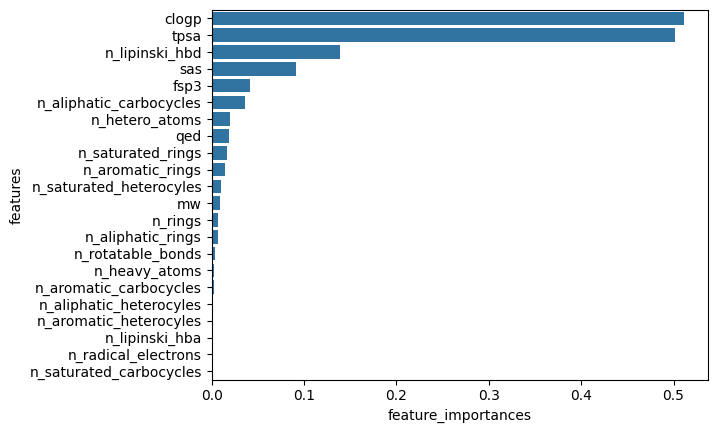

In [38]:
# Using the function feat_imp_plot() on perm_imp result to show plot
feat_imp_plot(perm_imp, X_mp4_df)

It generated a different feature importances ranking, although somewhat similar to the previous one.

<br>

###### **SHAP approach**

SHAP values [@lundberg2020local2global, @shapley1953] were used here to provide another way to figure out feature importances. The GitHub repository for this SHAP approach could be accessed [here](https://github.com/shap/shap).

SHAP's TreeExplainer() was based on Tree SHAP algorithms [@lundberg2020local2global], and was used to show and explain feature importances within tree models. It could also be extended to boosted tree models such as LightGBM and XGBoost and also other tree models (as explained by the GitHub repository README.md and its documentation link provided). It was also a model-agnostic method, which could be quite handy.

[*Other reference*](https://mljar.com/blog/feature-importance-in-random-forest/)

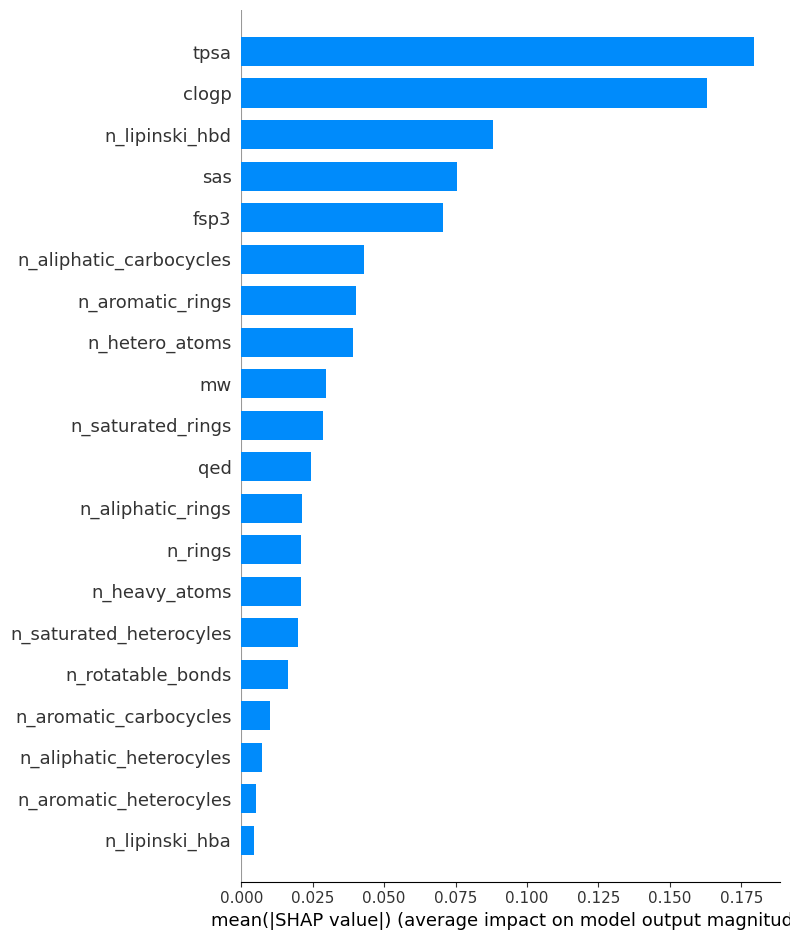

In [39]:
shap_explainer = shap.TreeExplainer(rfreg)

# X_test needs to be a dataframe (not numpy array)
# otherwise feature names won't show in plot
shap_values = shap_explainer.shap_values(X_mp_test_df)

# Horizontal bar plot
shap.summary_plot(shap_values, X_mp_test_df, plot_type = "bar")

Dot plot version:

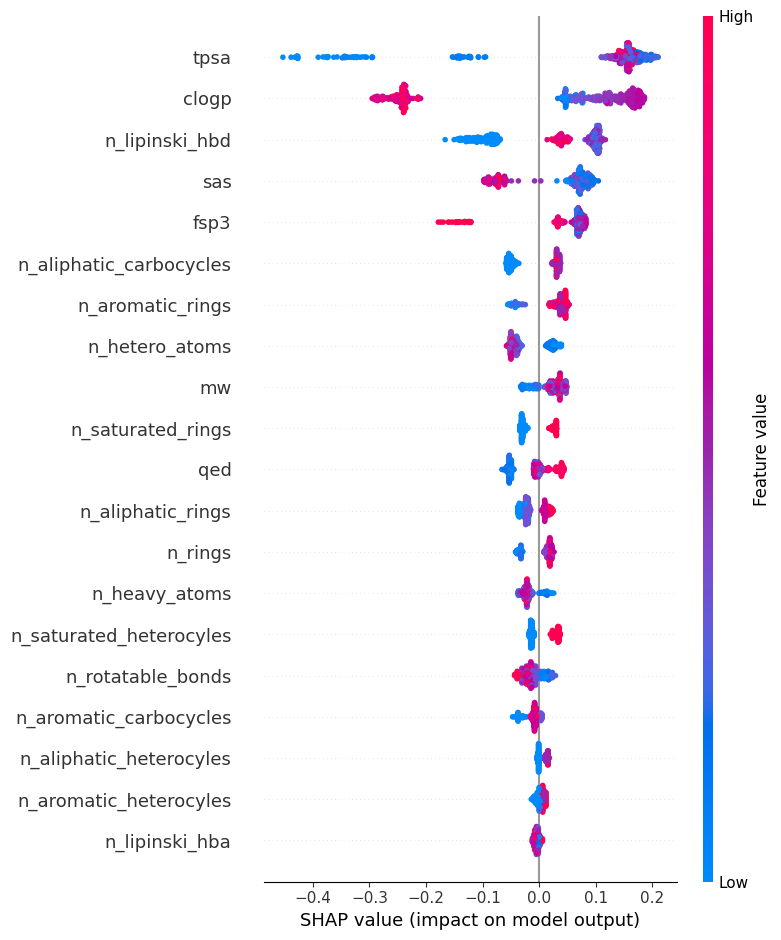

In [40]:
shap.summary_plot(shap_values, X_mp_test_df)

Violin plot:

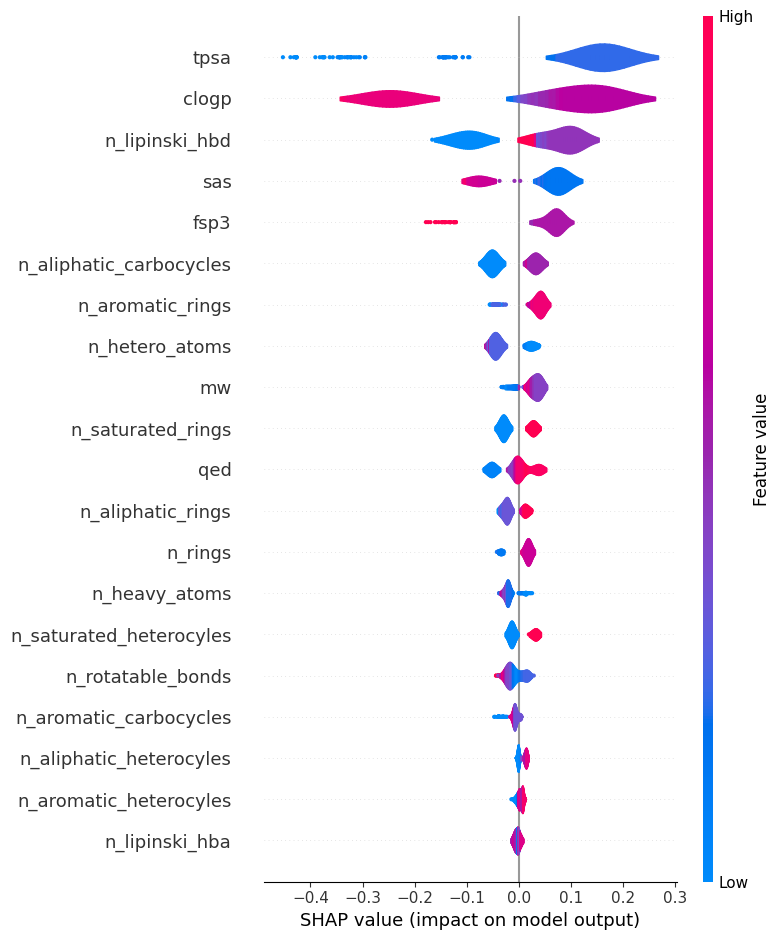

In [41]:
shap.summary_plot(shap_values, X_mp_test_df, plot_type = "violin")

# Alternative plot option: "layered_violin"

<br>

##### **Hyperparameter tuning**

An example was shown below on tuning the number of trees (n_estimators) used in the random forest model.

In [42]:
# Function code adapted with thanks from ML Mastery 
# https://machinelearningmastery.com/random-forest-ensemble-in-python/

# ---Evaluate a list of models with different number of trees---

# Define dataset by using the same training dataset as above
X, y = X_mp4, y_mp4

# Define function to generate a list of models with different no. of trees
def models():
    # Create empty dictionary (key, value pairs) for models
    models = dict()
    # Test different number of trees to evaluate
    no_trees = [50, 100, 250, 500, 1000]
    for n in no_trees:
        models[str(n)] = RandomForestRegressor(n_estimators=n)
    return models


# Define function to evaluate a single model using cross-validation
def evaluate(model, X, y):

    # RepeatedStratifiedKFold usually for binary or multi-class labels 
    # - ref link: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    # so using ReaptedKFold instead
    cross_val = RepeatedKFold(n_splits=10, n_repeats=15, random_state=1)
    # Run evaluation process & collect cv scores
    # Since estimator/model was based on DecisionTreeRegressor, 
    # using neg_mean_squared_error metric
    # n_jobs = -1 meaning using all processors to run jobs in parallel
    scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cross_val, n_jobs=-1)
    return scores


# Evaluate results
# Run models with different RepeatedKFold & different no. of tress
# with results shown as diff. trees with calculated mean cv scores & std

# Obtain diff. models with diff. trees via models function
models = models()

# Create empty lists for results & names
results, names = list(), list()

# Create a for loop to iterate through the list of diff. models
for name, model in models.items():
    # Run the cross validation scores via evaluate function
    scores = evaluate(model, X, y)
    # Collect results
    results.append(scores)
    # Collect names (different no. of trees)
    names.append(name)
    # Show the average mean squared errors and corresponding standard deviations 
    # for each model with diff. no. of trees
    print((name, mean(scores), std(scores)))

('50', -1.651483714670638, 1.625622475827701)
('100', -1.6623480288656514, 1.6446321645181243)
('250', -1.6485277822776498, 1.5925283471271743)
('500', -1.6343493399100582, 1.5902606660022778)
('1000', -1.6471292010474672, 1.60540246532959)


The negated version of the mean squared error (neg_mean_squared_error) was due to how the scoring parameter source code was written in *scikit-learn*. It was written this way to take into account of both *scoring* and *loss* functions (links provided below for further explanations). All scoring metrics could be accessed [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter) for *scikit-learn*.

Reference links to help with understanding neg_mean_squared_error:

1.  [scikit-learn source code](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/metrics/\_scorer.py#L624)

2.  [StackOverflow answer](https://stackoverflow.com/questions/48244219/is-sklearn-metrics-mean-squared-error-the-larger-the-better-negated)

Also, the random forest algorithm was stochastic in nature, meaning that every time hyperparameter tuning took place, it would generate different scores due to random bootstrap sampling. The best approach to evaluate model performance during the cross-validation process was to use the average outcome from several runs of cross-validations, then fit the hyperparameters on a final model, or getting several final models ready and then obtaining the average from these models instead.

Below was a version of boxplot plotted using Matplotlib showing the differences in the distributions of the cross validation scores and mean squared errors between different number of trees.

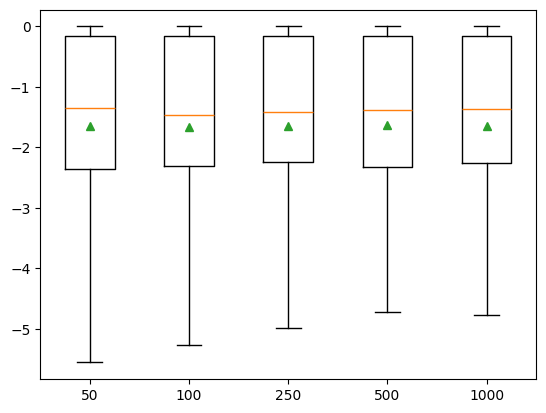

In [43]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

To plot this in Seaborn, I had to prepare the data slightly differently to achieve a different version of the boxplot. Matplotlib was a bit more straightforward to use without these steps.

I also used natural sort to sort numerical values ([GitHub repository](https://github.com/SethMMorton/natsort)). Otherwise, if using sort_values() only, it would only sort the numbers in lexicographical order (i.e. by first digit only), which was not able to show the tree numbers in ascending order.

In [44]:
# Combine results & names lists into dataframe
cv_results = pd.DataFrame(results, index = [names])

In [45]:
# Reset index and rename the number of trees column
cv_results = cv_results.reset_index().rename(columns={"level_0": "Number_of_trees"})

In [46]:
# Melt the dataframe by number of trees column
cv_results = cv_results.melt(id_vars="Number_of_trees")

In [47]:
# Sort by the number of trees column
cv_results = cv_results.sort_values(
    by="Number_of_trees",
    key=lambda x: np.argsort(index_natsorted(cv_results["Number_of_trees"]))
)

<Axes: xlabel='Number_of_trees', ylabel='value'>

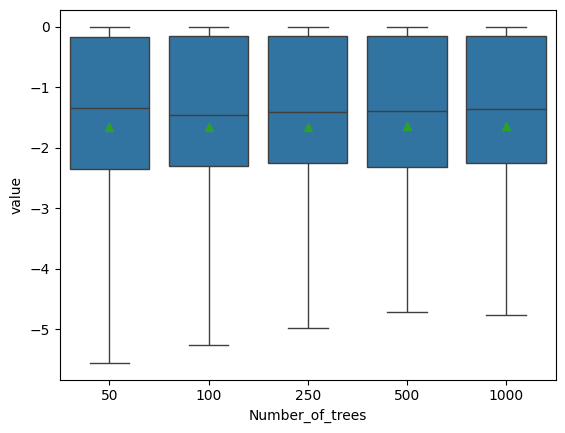

In [48]:
# Seaborn boxplot
sns.boxplot(cv_results, x="Number_of_trees", y="value", showmeans=True)

The Seaborn boxplot shown should be very similar to the Matplotlib one.

Other hyperparameters that could be tuned included: 

-   tree depths (max_depth)

-   number of samples (max_samples) 

-   number of features (max_features) - I didn't use RDKit to generate molecular features for this post (Datamol version was used instead) which would provide around 209 at least (trying to keep the post at a readable length), but I think this might be a better option when doing cross-validations in model evaluations

-   number of nodes (max_leaf_nodes)

I've decided not to code for these other hyperparameters in the cross-validation step due to length of post (the function code used in cross-validation above could be further adapted to cater for other hyperparameters mentioned here), but they should be looked into if doing full-scale and comprehensive ML using the ensemble random forest algorithm.

<br>

##### **Final words**

Random forest was known to be a black-box ML algorithm [@bruce2020], which was completely different from the white-box ML style revealed in decision tree graphs. Feature importances was therefore crucial to shed some lights and remove some layers of the black-box nature in random forest by showing which features were contributing towards model accuracy by ranking features used to train the model. Cross-validation was also vital to avoid over-fitting (which was more applicable to depth of trees), although in some other cases (e.g. number of trees), it was mentioned that it was unlikely the model would be overfitted. Other options available in *scikit-learn* ensemble methods that I didn't get time to try were using voting classifier/regressor and stacking models to reduce biases in models, which might be very useful in other cases.

Few things I've thought of that I could try to improve what I did here was that I should really look for a different set of testing data, rather than using the max phase splits, which was not that ideal. However, as a lot of us are aware, good drug discovery data are hard to come by (a long-standing and complicated problem), I probably need some luck while looking for a different set of drug discovery data later. Another approach that I could try was that I could use RandomForestClassifier() instead on max phase prediction of these small molecules, rather than making pKi value predictions. This might involve re-labelling the max phases for these compounds into a binary or class labels, then I could use the imbalance-learn package to try and alleviate the problem with imbalanced datasets. Nevertheless, I had some fun working on this post and learnt a lot while doing it, and I hope some of the readers might find this post helpful or informative at least.

<br>

##### **Acknowledgement**

I'd like to thank all the authors, developers and contributors who worked towards all of the open-source packages or libraries used in this post. I'd also like to thank all of the other senior cheminformatics and ML practitioners who were sharing their work and knowledge online. 